In [2]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [4]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')

OBJETIVO DE ESTE NOTEBOOK:
- DESCARGAR DE DISTINTOS ORIGENES LOS DATOS DE LOS ACTIVOS DEL IBEX35
- COMPARAR LOS DATOS OBTENIDOS 

## CARGA DE COMPOSICIÓN HISTÓRICA DE IBEX35

In [5]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

,Activo,Inclusion,Exclusion
0,ACE,1991-01-02,2003-06-02
1,ACX,1991-01-02,1991-07-01
2,ALB,1991-01-02,1991-07-01
3,ASL,1991-01-02,1994-01-03
4,BBV,1991-01-02,2000-01-31


In [6]:
# ibex_constituents['Exclusion'] -= BDay(1)

# ibex_constituents['Inclusion'] = ibex_constituents['Inclusion'].dt.date
# ibex_constituents['Exclusion'] = ibex_constituents['Exclusion'].dt.date

# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%Y-%m-%d')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna(today,inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

### DESCARGAMOS LOS DATOS DE YAHOO FINANCE

In [7]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
raw_folder = 'raw/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []

indexes = ibex_constituents[ibex_constituents['Activo'].isin(['ACE'])].index

# for i in range(ibex_constituents.shape[0]):
for i in indexes:

    try:
        ticker = ibex_constituents.Ticker[i] + '.MC'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        full_path = raw_folder + file_name
        
        stock = yf.download(ticker)
        stock = pd.DataFrame(stock)
        
        table = pa.Table.from_pandas(stock)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        failed_loads.append(ticker)
        continue



[*********************100%***********************]  1 of 1 completed
SCYR
[*********************100%***********************]  1 of 1 completed
SCYR_1
[*********************100%***********************]  1 of 1 completed
SCYR_2


In [40]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
preprocessed_folder = 'preprocessed/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []

indexes = ibex_constituents[ibex_constituents['Activo'].isin(['SCYR','SCYR_1','SCYR_2'])].index

# for i in range(ibex_constituents.shape[0]):
for i in indexes:

    try:
        ticker = ibex_constituents.Ticker[i] + '.MC'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        start_date = ibex_constituents.Inclusion[i]
        end_date = ibex_constituents.Exclusion[i]
        full_path = preprocessed_folder + file_name
        
        stock = yf.download(ticker, start=start_date, end=end_date)
        print(stock)
        stock = pd.DataFrame(stock)
        
        table = pa.Table.from_pandas(stock)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        failed_loads.append(ticker)
        continue



[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2003-06-02  8.086692  8.128164  7.895933  8.086692   5.068855  6043269
2003-06-03  8.078402  8.161336  7.937396  8.078402   5.063657   822236
2003-06-04  8.119864  8.169636  8.003749  8.119864   5.089646  1372029
2003-06-05  8.169636  8.169636  8.078402  8.169636   5.120844   742405
2003-06-06  8.045221  8.235989  8.045221  8.045221   5.042859   563733
...              ...       ...       ...       ...        ...      ...
2004-06-24  9.704034  9.836740  9.662563  9.704034   6.293741   353856
2004-06-25  9.704034  9.828440  9.662563  9.704034   6.293741   366200
2004-06-28  9.596210  9.745506  9.596210  9.596210   6.223811   794648
2004-06-29  9.488385  9.604501  9.405442  9.488385   6.197623   651007
2004-06-30  9.330798  9.496676  9.289326  9.330798   6.094692  6042853

[283 ro

In [48]:
ibex_constituents[ibex_constituents['Activo']=='SOL'].index[0]

64

In [50]:
ibex_constituents.Exclusion[i]

Timestamp('2003-01-02 00:00:00')

In [37]:

# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
preprocessed_folder = 'preprocessed/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []
i = ibex_constituents[ibex_constituents['Activo']=='BBV'].index[0]

ticker = 'BBVA' + '.MC'
print(i)
file_name = ibex_constituents.Activo[i] +'.parquet'
start_date = ibex_constituents.Inclusion[i]
end_date = ibex_constituents.Exclusion[i]
full_path = preprocessed_folder + file_name

stock = yf.download(ticker, start=start_date, end=end_date)
print(stock)
stock = pd.DataFrame(stock)

table = pa.Table.from_pandas(stock)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
print(ibex_constituents.Activo[i])


4
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2000-01-03  13.690602  13.757854  13.594527  13.623349   4.755257   8244257
2000-01-04  13.450416  13.536882  13.219837  13.267874   4.631179   8522096
2000-01-05  13.142977  13.210230  12.912399  12.970044   4.527219  12159826
2000-01-06  12.970044  12.970044  12.970044  12.970044   4.527219         0
2000-01-07  13.248659  13.248659  12.998866  13.133370   4.584228  62261944
2000-01-10  13.277482  13.277482  12.902791  12.922006   4.510450  58740351
2000-01-11  12.873969  12.893184  12.537709  12.662605   4.419908   6761292
2000-01-12  12.643391  12.643391  12.393597  12.518494   4.405469   8266754
2000-01-13  12.489672  12.537709  12.105374  12.211056   4.297278   9372669
2000-01-14  12.297523  12.480064  12.230271  12.451242   4.381802   8538333
2000-01-17  12.53

<AxesSubplot: xlabel='Date'>

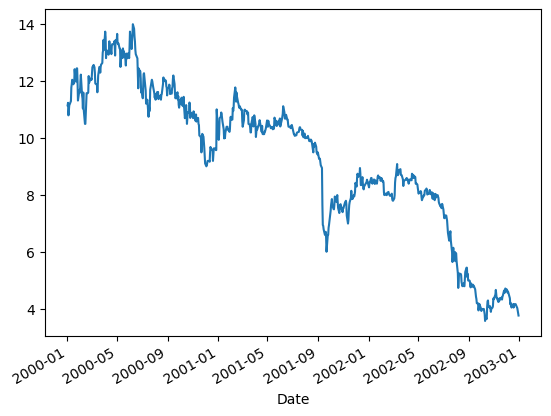

In [61]:
stock['Close'].plot()

In [18]:
ibex_constituents[ibex_constituents['Activo']=='ELE_1'].index[0]

Int64Index([145], dtype='int64')

In [27]:
stock_prices

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,11.60,11.60,11.05,11.15,-12.893392,164558
2000-01-04,11.00,11.50,10.77,11.24,-12.997465,201679
2000-01-05,10.91,11.44,10.80,10.80,-12.488667,165066
2000-01-07,11.29,11.29,10.90,11.15,-12.893392,238820
2000-01-10,11.40,11.41,11.02,11.27,-13.032155,272760
...,...,...,...,...,...,...
2002-12-19,4.09,4.13,4.02,4.09,3.502554,338873
2002-12-20,4.17,4.20,4.06,4.17,3.571063,207074
2002-12-23,4.17,4.19,4.06,4.17,3.571063,266528


In [25]:
stock_prices = pq.read_table(download_s3_parquet_file(s3, bucket_name,'preprocessed/yfinance/SOL.parquet')).to_pandas()
stock_prices.index = pd.to_datetime(stock_prices.index).strftime('%Y-%m-%d')
negative_adj_close = stock_prices[stock_prices['Adj Close']<0]
if negative_adj_close.empty:
    close_price = stock_prices['Adj Close']
else:
    close_price = stock_prices['Close']

close_price.index = pd.to_datetime(close_price.index).strftime('%Y-%m-%d')
close_price

Date
2000-01-03   -12.893392
2000-01-04   -12.997465
2000-01-05   -12.488667
2000-01-07   -12.893392
2000-01-10   -13.032155
                ...    
2002-12-19     3.502554
2002-12-20     3.571063
2002-12-23     3.571063
2002-12-27     3.451172
2002-12-30     3.228515
Name: Adj Close, Length: 743, dtype: float64

<AxesSubplot: xlabel='Date'>

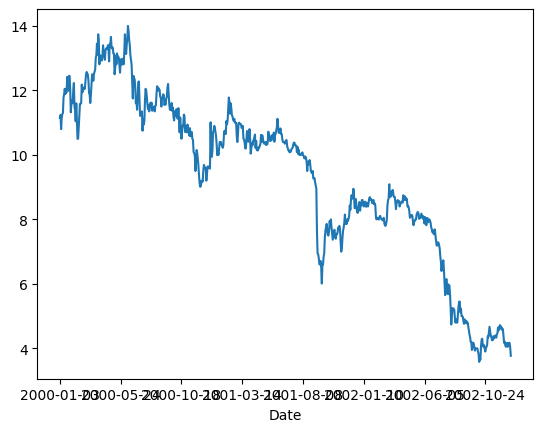

In [72]:
close_price.plot()

In [33]:
preprocessed_folder = 'preprocessed/yfinance/'
raw_path = bucket_name + preprocessed_folder
objects_dict = s3_client.list_objects_v2(
        Bucket=bucket_name,
        Prefix ='preprocessed/yfinance')
raw_filepaths = [item['Key'] for item in objects_dict['Contents'] if item['Key'].endswith('.parquet')]
act_list = [i.split('/')[-1].replace('.parquet','') for i in raw_filepaths]

In [34]:
ibex_historical_data = {}
processed_folder = 'processed/yfinance/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [35]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [36]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
for i in range(len(raw_filepaths)):
    
    try:
        stock_prices = pq.read_table(download_s3_parquet_file(s3, bucket_name,raw_filepaths[i])).to_pandas()
        stock_prices.index = pd.to_datetime(stock_prices.index).strftime('%Y-%m-%d')
        returns = np.log(stock_prices['Adj Close']).diff()[1:]
        min_returns = returns.min().min()
        
        negative_adj_close = stock_prices[stock_prices['Adj Close']<0]
        print(negative_adj_close)
        if (negative_adj_close.empty):# | (min_returns > -1):
            close_price = stock_prices['Adj Close']
        else:
            close_price = stock_prices['Close']
            print(raw_filepaths[i])

        close_price.index = pd.to_datetime(close_price.index).strftime('%Y-%m-%d')
        ibex_historical_data[act_list[i]] = close_price
    except:
        ibex_historical_data[act_list[i]] = np.nan
        
ibex_historical_data = pd.DataFrame(ibex_historical_data)

table = pa.Table.from_pandas(ibex_historical_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2000-07-03  40.500000  42.250000  39.500000  41.650002  -1.961556    46596
2000-07-04  42.000000  42.150002  40.400002  40.599998  -1.912106    83363
2000-07-05  40.610001  41.099998  39.900002  40.000000  -1.883848   202897
2000-07-06  40.099998  41.299999  40.099998  40.660000  -1.914931   196208
2000-07-10  41.299999  41.599998  41.099998  41.240002  -1.942247   169478
...               ...        ...        ...        ...        ...      ...
2001-01-08  39.900002  41.099998  39.500000  41.049999  -1.933298   146029
2001-01-09  41.099998  41.750000  39.709999  40.150002  -1.890912   148356
2001-01-10  40.250000  40.439999  39.900002  40.400002  -1.902686   110611
2001-01-11  40.470001  40.799999  40.290001  40.650002  -1.914460  1063247
2001-01-12  40.360001  41.200001  40.099998  41.000000  -1.930944   191471

[131 rows x 6 columns]
p

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2000-01-03  19.700001  19.750000  18.879999  19.010000  -4.884562  3615680
2000-01-04  18.879999  18.879999  18.200001  18.500000  -4.753520  4048543
2000-01-05  18.200001  18.680000  18.129999  18.639999  -4.789490  4688995
2000-01-07  18.900000  19.350000  18.860001  19.309999  -4.961645  4027102
2000-01-10  19.549999  19.549999  19.059999  19.309999  -4.961645  2533020
...               ...        ...        ...        ...        ...      ...
2000-06-26  21.280001  21.320000  20.850000  21.250000  -5.460122  5896996
2000-06-27  21.100000  21.340000  20.809999  20.850000  -5.357343  3900422
2000-06-28  20.850000  20.900000  20.500000  20.690001  -5.316232  7792265
2000-06-29  20.690001  20.770000  20.090000  20.160000  -5.180052  4060382
2000-06-30  20.250000  20.500000  20.090000  20.290001  -5.213454  3817463

[124 rows x 6 columns]
p

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2000-01-07  13.654850  13.840339  13.505032  13.840339  -0.662828  446713
2000-01-10  14.254122  14.254122  13.897413  13.911681  -0.666245  365016
2000-01-11  13.890278  14.018694  13.447958  13.619179  -0.652237  362828
2000-01-12  13.612045  13.983023  13.219664  13.961620  -0.668636  418190
2000-01-13  13.840339  14.011560  13.398019  13.433690  -0.643353  308696
...               ...        ...        ...        ...        ...     ...
2000-06-26  14.411075  14.553759  14.097170  14.318330  -0.685720  368365
2000-06-27  14.553759  14.682174  13.733326  13.840339  -0.662828  428383
2000-06-28  13.904547  14.068633  13.676253  13.768997  -0.659411  222847
2000-06-29  13.940218  13.940218  13.483629  13.483629  -0.645745  240083
2000-06-30  13.754729  14.753516  13.376616  14.125707  -0.676495  516174

[126 rows x 6 columns]
preprocessed/y

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


             Open   High    Low  Close  Adj Close   Volume
Date                                                      
2000-10-03  12.20  12.76  12.19  12.34  -0.579203   498316
2000-10-04  12.40  12.65  12.34  12.53  -0.588121   395452
2000-10-05  12.66  12.68  12.31  12.31  -0.577795   181875
2000-10-06  12.47  12.49  12.25  12.29  -0.576856   215041
2000-10-09  12.38  12.45  12.00  12.03  -0.564653   372529
...           ...    ...    ...    ...        ...      ...
2001-06-25  10.80  10.89  10.53  10.53  -0.494247  1216107
2001-06-26  10.53  10.69   9.98  10.18  -0.477819  2096148
2001-06-27  10.30  10.65  10.25  10.65  -0.499880  1220763
2001-06-28  10.70  10.90  10.25  10.84  -0.508798   675831
2001-06-29  10.87  10.90  10.33  10.40  -0.488145   808290

[191 rows x 6 columns]
preprocessed/yfinance/IDR.parquet


C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2001-07-02  3.758  3.840  3.728  3.820  -0.136871   8634625
2001-07-03  3.772  3.822  3.772  3.820  -0.136871  20450495
2001-07-04  3.820  3.830  3.766  3.796  -0.136011   4993255
2001-07-05  3.796  3.810  3.730  3.730  -0.133647  16127145
2001-07-06  3.760  3.760  3.700  3.700  -0.132572   6726610
...           ...    ...    ...    ...        ...       ...
2002-09-18  4.062  4.098  4.000  4.052  -0.146037   4711710
2002-09-19  4.022  4.150  3.960  4.020  -0.144884   9985435
2002-09-20  4.076  4.350  3.966  4.280  -0.154255  16214830
2002-09-23  4.210  4.228  4.082  4.200  -0.151371   8471515
2002-09-24  4.200  4.260  4.106  4.200  -0.151371   8724120

[308 rows x 6 columns]
preprocessed/yfinance/ITX.parquet
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empt

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


{'ResponseMetadata': {'RequestId': 'MDCJ8KCH6JBTXCYM',
  'HostId': 'OvSyfLdAn/RlMXQuXUZDXnSZ336y7EudtX+xuo3k0XJM+jvuRHREScFo93H8vGVZFud1N1imwzQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OvSyfLdAn/RlMXQuXUZDXnSZ336y7EudtX+xuo3k0XJM+jvuRHREScFo93H8vGVZFud1N1imwzQ=',
   'x-amz-request-id': 'MDCJ8KCH6JBTXCYM',
   'date': 'Mon, 14 Aug 2023 21:19:19 GMT',
   'x-amz-version-id': 'kuiyqMPLB1m9VR4oy4ILm8TfoeRIf_TM',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"24d031bae94a9def08606423cb65642e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"24d031bae94a9def08606423cb65642e"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'kuiyqMPLB1m9VR4oy4ILm8TfoeRIf_TM'}

<AxesSubplot: xlabel='Date'>

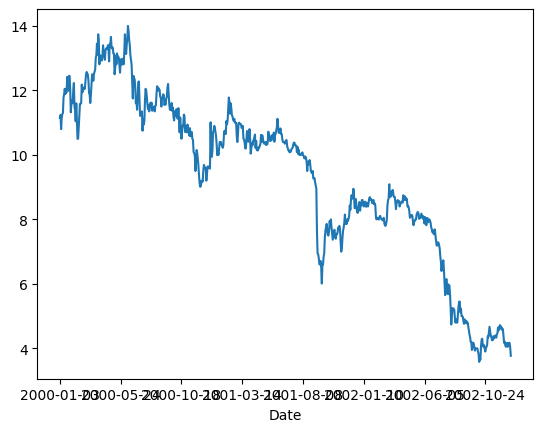

In [31]:
ibex_historical_data['SOL'].dropna().plot()

In [83]:
np.log(ibex_historical_data).diff()[1:].min().min()

-2.022848337494799

<BarContainer object of 6099 artists>

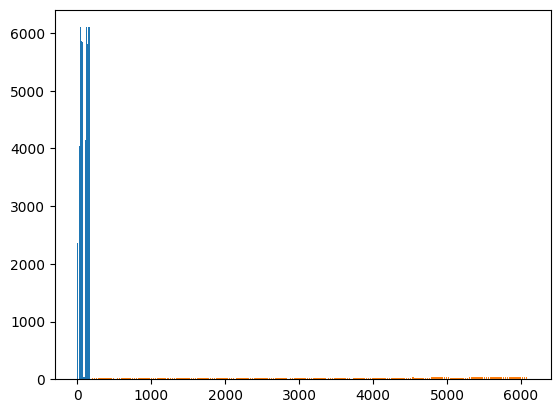

: 

In [84]:
plt.bar(range(ibex_historical_data.shape[1]),ibex_historical_data.isnull().sum())
plt.bar(range(ibex_historical_data.shape[0]),ibex_historical_data.notna().sum(axis=1))

In [30]:
failed_loads = ibex_historical_data.columns[ibex_historical_data.isnull().values.all(axis=0)]
failed_loads, len(failed_loads)

(Index(['A3TV', 'ABG.P', 'ABG.P_1', 'ABG', 'ACR', 'ACX', 'AGR', 'AGS', 'AGS_1',
        'AGS_2',
        ...
        'UNI', 'URA', 'URB', 'VAL', 'VAL_1', 'VDR', 'VIS', 'VIS_1', 'ZEL',
        'ZOT'],
       dtype='object', length=103),
 103)